<a href="https://colab.research.google.com/github/pyannote/pyannote-audio/blob/develop/tutorials/training_a_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training a voice activity detection model from scratch

Voice activity detection (VAD) is the task of detecting speech regions in a given audio stream or recording.

We initialize a VAD *task* that describes how the model will be trained:

* `ami` indicates that we will use files available in `ami.train()`.
* `duration=2.` and `batch_size=128` indicates that the model will ingest batches of 128 two seconds long audio chunks.

In [ ]:
from pyannote.database import registry, FileFinder
from pyannote.audio.tasks import MultiLabelSegmentation
from pyannote.audio.models.segmentation import PyanNet, SSeRiouSS
from voice_type_classifier import VoiceTypeClassifier
from pytorch_lightning import Trainer

file_finder = FileFinder()
# Load the ChildLens dataset
registry.load_database("/home/nele_pauline_suffo/projects/pyannote-audio-train/database.yml")
protocol = registry.get_protocol('ChildLens.SpeakerDiarization.audio', preprocessors={"audio": lambda x: str(file_finder(x))})
# Define the task for multi-label segmentation
mls_task = MultiLabelSegmentation(
    protocol,
    duration=2.0,
    batch_size=32,
    num_workers=4,
    classes=['kchi', 'och', 'mal', 'fem', 'ovh']
)

# Create the model
mls_model = SSeRiouSS(task=mls_task, wav2vec="WAVLM_BASE")
# mls_model = VoiceTypeClassifier(
#     task=mls_task,
#     hidden_size=256,
#     num_transformer_layers=4
# )
# Create a PyTorch Lightning trainer and fit the model
trainer = Trainer(devices=1, max_epochs=1)
trainer.fit(mls_model)


/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/pyannote/database/registry.py:499: UserWarning: Replacing existing ChildLens.SpeakerDiarization.audio protocol by the one defined in '/home/nele_pauline_suffo/projects/pyannote-audio-train/database.yml'.
  warnings.warn(


Protocol ChildLens.SpeakerDiarization.audio does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


Downloading: "https://download.pytorch.org/torchaudio/models/wavlm_base.pth" to /home/nele_pauline_suffo/.cache/torch/hub/checkpoints/wavlm_base.pth
100%|██████████| 360M/360M [00:03<00:00, 116MB/s]  
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/pyannote/database/protocol/protocol.py:140: UserWarning: Existing precomputed key "annotation" has been modified by a preprocessor.
  warnings.warn(msg.format(key=key))
/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/pyannote/database/protocol/protocol.py:140: UserWarning: Existing precomputed key "annotation" has been modified by a preprocessor.
  warnings.warn(msg.format(key=key))

  | Name              | Type             | Params | Mode  | In sizes     | Out sizes                                 
---------------------------------------------------------------------------

/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:122: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Epoch 0:   0%|          | 0/2571 [00:00<?, ?it/s] 

/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/torch_audiomentations/core/transforms_interface.py:221: UserWarning: target_rate is required by Identity. It has been automatically inferred from targets shape to 50. If this is incorrect, you can pass it directly.
  warnings.warn(
/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/torch_audiomentations/core/transforms_interface.py:221: UserWarning: target_rate is required by Identity. It has been automatically inferred from targets shape to 50. If this is incorrect, you can pass it directly.
  warnings.warn(
/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/torch_audiomentations/core/transforms_interface.py:221: UserWarning: target_rate is required by Identity. It has been automatically inferred from targets shape to 50. If this is incorrect, you can pass it directly.
  warnings.warn(
/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-p

Epoch 0:  13%|█▎        | 338/2571 [15:36<1:43:05,  0.36it/s, v_num=13]

## Inference

Once trained, the model can be applied to a test file:
Because the model was trained on 2s audio chunks and that test files are likely to be much longer than that, we wrap the `model` with an `Inference` instance: it will take care of sliding a 2s window over the whole file and aggregate the output of the model.

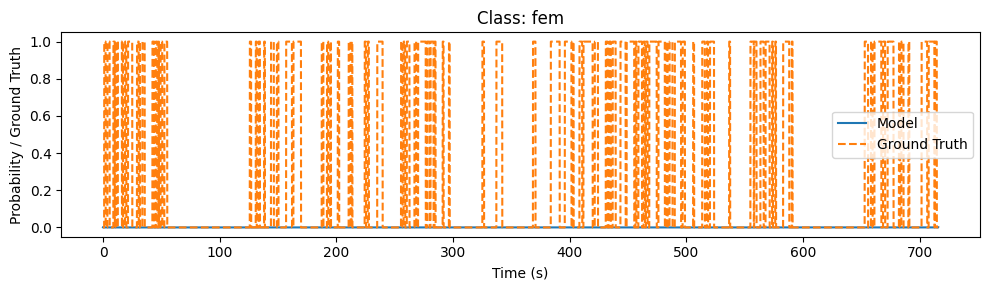

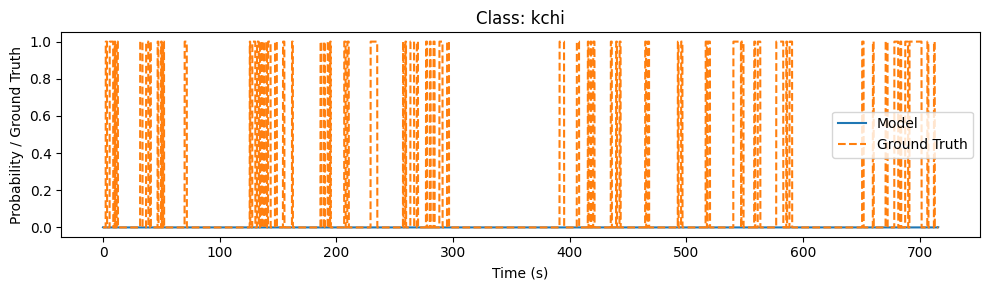

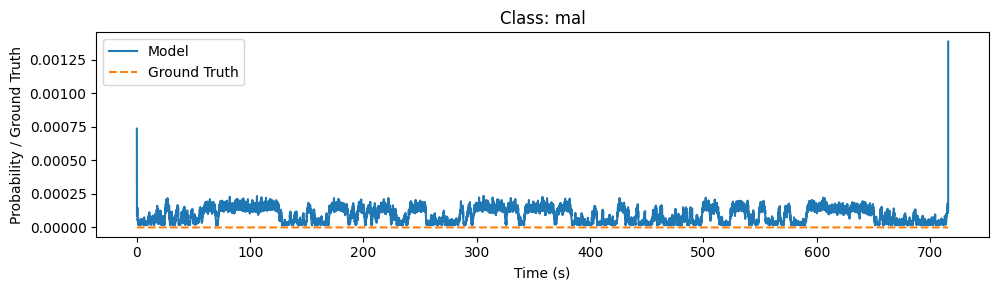

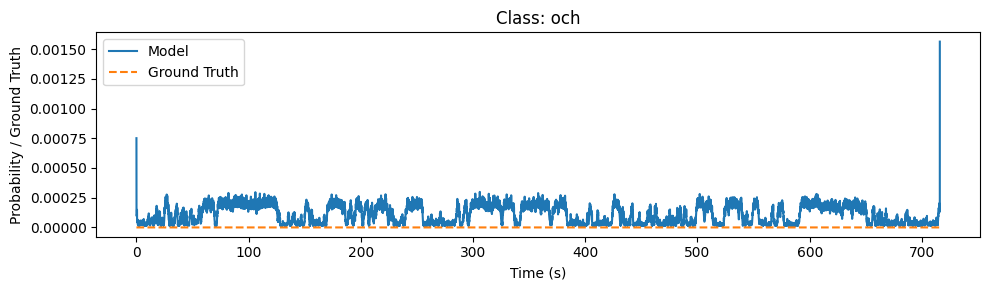

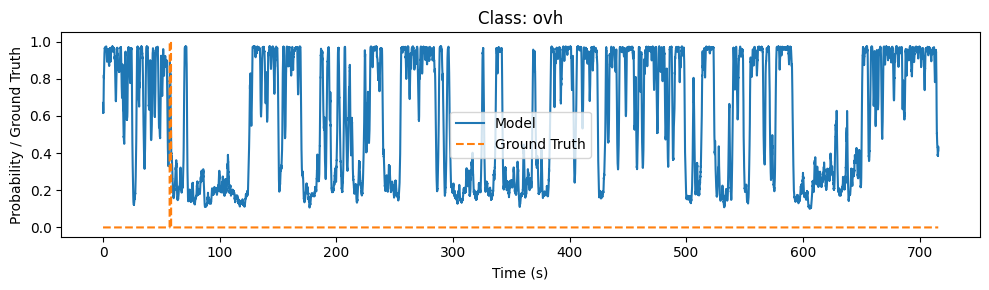

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pyannote.audio import Inference

# run inference on the test file
mls = Inference(mls_model, window="sliding", duration=2.0, step=0.5)
test_file = next(protocol.test())
mls_probability = mls(test_file)

# define time axis
num_frames = mls_probability.data.shape[0]
start = mls_probability.sliding_window.start
step = mls_probability.sliding_window.step
time = np.arange(num_frames) * step + start

class_names = mls_model.specifications.classes

# create a figure for each class
# and plot the model probabilities and ground truth
# (ground truth is 1 if the class is present, 0 otherwise)
for idx, class_name in enumerate(class_names):
    plt.figure(figsize=(10, 3))
    # Model probabilities
    plt.plot(time, mls_probability.data[:, idx], label="Model", color="C0")
    # Ground truth
    gt = np.zeros_like(time)
    for segment, _, label in test_file["annotation"].itertracks(yield_label=True):
        if label == class_name:
            mask = (time >= segment.start) & (time < segment.end)
            gt[mask] = 1
    plt.plot(time, gt, "--", label="Ground Truth", color="C1")
    plt.title(f"Class: {class_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Probability / Ground Truth")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Pipeline

Almost there! To obtain the final speech regions, we need to apply a detection threshold.  
For that, we rely on the voice activity detection pipeline whose hyper-parameters are set manually:
- `onset=0.6`: mark region as `active` when probability goes above 0.6
- `offset=0.4`: switch back to `inactive` when probability goes below 0.4
- `min_duration_on=0.0`: remove `active` regions shorter than that many seconds
- `min_duration_off=0.0`: fill `inactive` regions shorter than that many seconds


More details about those hyper-parameters are provided in Figure 2 of [that paper](https://arxiv.org/abs/2104.04045).

In [8]:
from pyannote.audio.pipelines import MultiLabelSegmentation as MultiLabelSegmentationPipeline
pipeline = MultiLabelSegmentationPipeline(segmentation=mls_model, share_min_duration=True, fscore=True)

# Define the initial parameters for the pipeline
initial_params = {
    "thresholds": {
        "kchi": {"onset": 0.6, "offset": 0.4},
        "och": {"onset": 0.6, "offset": 0.4},
        "fem": {"onset": 0.6, "offset": 0.4},
        "mal": {"onset": 0.6, "offset": 0.4},
        "ovh": {"onset": 0.6, "offset": 0.4},
    },
    "min_duration_on": 0.0,
    "min_duration_off": 0.0,
}

# Instantiate the pipeline with the parameters
pipeline.instantiate(initial_params)

## Evaluation

In [27]:
from pyannote.metrics.detection import DetectionPrecisionRecallFMeasure
from pyannote.core import Annotation

class_labels = ["kchi", "och", "fem", "mal", "ovh"]

def filter_annotation_by_label(annotation, label):
    filtered = Annotation()
    for segment, _, l in annotation.itertracks(yield_label=True):
        if l == label:
            filtered[segment] = l
    return filtered

def annotation_to_list(annotation):
    return [
        (segment.start, segment.end, label)
        for segment, _, label in annotation.itertracks(yield_label=True)
    ]
    
# Store per-class F1
per_class_f1 = {}

for class_label in class_labels:
    # Initialize a new metric for each class
    detection_f1_class = DetectionPrecisionRecallFMeasure(collar=0, skip_overlap=False)
    for file in protocol.test():
        # Filter reference and hypothesis for the current class
        reference = file['annotation']
        reference_filtered = filter_annotation_by_label(reference, class_label)

        hypothesized = pipeline(file)
        hypothesized_filtered = filter_annotation_by_label(hypothesized, class_label)
        # Evaluate
        _ = detection_f1_class(reference_filtered, hypothesized_filtered, uem=file['annotated'])
    # Compute F1 for this class
    f1_score = abs(detection_f1_class)
    per_class_f1[class_label] = f1_score

# Print per-class F1-scores
print("Per-class F1-scores (filtered):")
for class_label in class_labels:
    print(f"  {class_label}: {per_class_f1[class_label]:.2f}")

# Optionally, compute macro-average F1-score over all classes
macro_f1 = sum(per_class_f1.values()) / len(per_class_f1)
print(f"Macro-average F1-score (filtered): {macro_f1:.2f}")

/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/pyannote/database/protocol/protocol.py:140: UserWarning: Existing precomputed key "annotation" has been modified by a preprocessor.
  warnings.warn(msg.format(key=key))
/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/pyannote/database/protocol/protocol.py:140: UserWarning: Existing precomputed key "annotation" has been modified by a preprocessor.
  warnings.warn(msg.format(key=key))


KeyboardInterrupt: 

## Optimizing Pipeline Hyperparameter

While good enough, the hyper-parameters that we chose manually, we can try to optimize `onset` and `offset` on the development (a.k.a. validation) set to get better performance (and freeze the other two hyper-parameters).

In [ ]:
pipeline.freeze({'min_duration_on': 0.0, 'min_duration_off': 0.0})

In [ ]:
from pyannote.pipeline import Optimizer

optimizer = Optimizer(pipeline)
optimizer.tune(list(ami.development()),
               warm_start=initial_params,
               n_iterations=20,
               show_progress=False)

optimized_params = optimizer.best_params
print(optimized_params)

In [ ]:
optimized_pipeline = pipeline.instantiate(optimized_params)

metric = DetectionErrorRate()

for file in protocol.test():
    speech = optimized_pipeline(file)
    _ = metric(file['annotation'], speech, uem=file['annotated'])

detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')